In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.stats import norm
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Constants

In [3]:
# Model dimensions
NUM_USERS = 16
NUM_ITEMS = 16
EMB_DIM = 64

In [4]:
# # Parameters (these work but sometimes lead to too large predictions)
# INITIAL_RND_AMPLITUDE = 1e-4
# PRIOR_PRECISION = 0.5
# LIKELIHOOD_PRECISION = 1.0

# Parameters
INITIAL_RND_AMPLITUDE = 1e-4
PRIOR_PRECISION = 1.0
LIKELIHOOD_PRECISION = 1.5

## Exact (Unnormalized) Posterior After First Rating For $K=1$

In [5]:
GRID = np.linspace(-3, 3, 101)
X, Y = np.meshgrid(GRID, GRID)

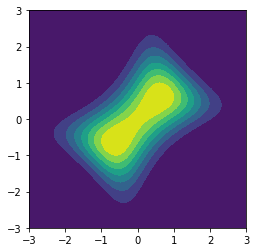

In [6]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.contourf(
    X, Y,
    norm.pdf(X, loc=0, scale=1/np.sqrt(PRIOR_PRECISION)) *
    norm.pdf(Y, loc=0, scale=1/np.sqrt(PRIOR_PRECISION)) *
    norm.pdf(X * Y, loc=1, scale=1/np.sqrt(LIKELIHOOD_PRECISION))
)

## Initialization

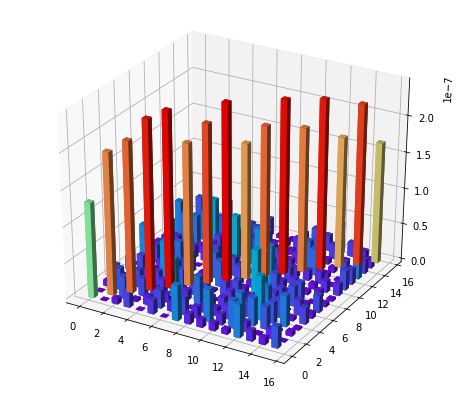

In [7]:
np.random.seed(123)
mu_i = np.random.uniform(-INITIAL_RND_AMPLITUDE, INITIAL_RND_AMPLITUDE, size=(NUM_ITEMS, EMB_DIM))
precision_ii = np.full((NUM_ITEMS, EMB_DIM), PRIOR_PRECISION)
precision_uu = np.full((NUM_USERS, EMB_DIM), PRIOR_PRECISION)
precision_ui = np.zeros((NUM_USERS, NUM_ITEMS, EMB_DIM))
nu_u = np.zeros((NUM_USERS, EMB_DIM))

# Plot item similarity.
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection = '3d')
item_similarity = np.abs(mu_i.dot(mu_i.T)).ravel()
I1, I2 = np.meshgrid(range(NUM_ITEMS), range(NUM_ITEMS))
ax.bar3d(
    I1.ravel(), I2.ravel(), 0*item_similarity,
    0.5, 0.5, item_similarity,
    cm.rainbow(item_similarity / item_similarity.max()))

# fig, ax = plt.subplots()
# item_similarity_plot = ax.imshow(np.abs(mu_i.dot(mu_i.T)))
# fig.colorbar(item_similarity_plot, ax=ax)

## Saddle Point After First Rating

In [8]:
def coordinate_ascent(item, user, rating):
    bias_i = precision_ii[item, :] * mu_i[item, :]
    
    other_correlations = (
        np.sum(precision_ui[user, :, :] * mu_i, axis=0) - precision_ui[user, item, :] * mu_i[item, :])

    # initialization
    opt_item_i = mu_i[item, :]
    opt_user_j = (
        nu_u[user, :] - other_correlations - precision_ui[user, item, :] * mu_i[item, :]
    ) / precision_uu[user, :]
    
    for i in range(10):
        prediction = opt_user_j.dot(opt_item_i)
        map_log_prob = (
            - LIKELIHOOD_PRECISION * (rating - prediction)**2
            - 0.5 * precision_ii[item, :].dot((mu_i[item, :] - opt_item_i)**2)
            - 0.5 * precision_uu[user, :].dot(opt_user_j**2)
            + (nu_u[user, :] - other_correlations - precision_ui[user, item, :] * opt_item_i).dot(opt_user_j)
        )
        print(f'iteration {i}: prediction = {prediction}; MAP log posterior probability = {map_log_prob}')

        mat_A = LIKELIHOOD_PRECISION * opt_item_i[:, None] * opt_item_i[None, :] + np.diag(precision_uu[user, :])
        vec_xi = (
            LIKELIHOOD_PRECISION * rating * opt_item_i
            + nu_u[user, :]
            - other_correlations - precision_ui[user, item, :] * opt_item_i
        )
        opt_user_j = np.linalg.solve(mat_A, vec_xi)

        mat_A = LIKELIHOOD_PRECISION * opt_user_j[:, None] * opt_user_j[None, :] + np.diag(precision_ii[item, :])
        vec_xi = (
            LIKELIHOOD_PRECISION * rating * opt_user_j
            + bias_i - precision_ui[user, item, :] * opt_user_j
        )
        opt_item_i = np.linalg.solve(mat_A, vec_xi)
        
    return opt_item_i, opt_user_j, other_correlations

In [9]:
def update(item, user, rating, opt_item_i, opt_user_j, other_correlations):
    mu_i[item, :] = opt_item_i
    precision_ii[item, :] += LIKELIHOOD_PRECISION * opt_user_j**2
    precision_uu[user, :] += LIKELIHOOD_PRECISION * opt_item_i**2
    precision_ui[user, item, :] += LIKELIHOOD_PRECISION * (
        (opt_item_i.dot(opt_user_j) - rating) + opt_item_i * opt_user_j)
    nu_u[user, :] = (
        precision_uu[user, :] * opt_user_j + other_correlations + precision_ui[user, item, :] * mu_i[item, :])

In [10]:
def new_rating(item, user, rating):
    opt_item_i, opt_user_j, other_correlations = coordinate_ascent(item, user, rating)
    update(item, user, rating, opt_item_i, opt_user_j, other_correlations)

In [11]:
def prediction(item, user):
    mu_j = (nu_u[user, :] - np.sum(precision_ui[user, :, :] * mu_i, axis=0)) / precision_uu[user, :]
    return mu_i[item, :].dot(mu_j)

In [12]:
# (precision_uu[user, :].dot(opt_user_j)) / precision_uu[user, :]

In [13]:
prediction(0, 0), prediction(0, 1), prediction(1, 0), prediction(1, 1)

(0.0, 0.0, 0.0, 0.0)

In [14]:
new_rating(0, 0, +1)
prediction(0, 0), prediction(0, 1), prediction(1, 0), prediction(1, 1)

iteration 0: prediction = 0.0; MAP log posterior probability = -1.5
iteration 1: prediction = 6.418547403425379e-07; MAP log posterior probability = -1.499998555827209
iteration 2: prediction = 5.3353698930060535e-06; MAP log posterior probability = -1.499989078565315
iteration 3: prediction = 3.2343696679817906e-05; MAP log posterior probability = -1.4999362306330166
iteration 4: prediction = 0.0001763234346124221; MAP log posterior probability = -1.4996578657360606
iteration 5: prediction = 0.00091998554342562; MAP log posterior probability = -1.4982279229069198
iteration 6: prediction = 0.004677650269825119; MAP log posterior probability = -1.4910363258842232
iteration 7: prediction = 0.02270088820267073; MAP log posterior probability = -1.4570037797266593
iteration 8: prediction = 0.09270416233402982; MAP log posterior probability = -1.3318207744460968
iteration 9: prediction = 0.2316511051795116; MAP log posterior probability = -1.1193647885588738


(0.3149973739325399, 0.0, 9.33391323999649e-07, 0.0)

In [15]:
new_rating(0, 1, +1)
prediction(0, 0), prediction(0, 1), prediction(1, 0), prediction(1, 1)

iteration 0: prediction = 0.0; MAP log posterior probability = -1.5
iteration 1: prediction = 0.5472912825065424; MAP log posterior probability = -0.5472698624928785
iteration 2: prediction = 0.5742861802123721; MAP log posterior probability = -0.5283629884541642
iteration 3: prediction = 0.5745894728165454; MAP log posterior probability = -0.5281686324404498
iteration 4: prediction = 0.5745942284835972; MAP log posterior probability = -0.5281655006287596
iteration 5: prediction = 0.5745945297697979; MAP log posterior probability = -0.5281652928012567
iteration 6: prediction = 0.5745946253829769; MAP log posterior probability = -0.5281652292919006
iteration 7: prediction = 0.5745946628101777; MAP log posterior probability = -0.5281652050085841
iteration 8: prediction = 0.5745946777032697; MAP log posterior probability = -0.5281651954408774
iteration 9: prediction = 0.5745946836531165; MAP log posterior probability = -0.5281651916339102


(0.8827779634387485,
 0.5745946860337889,
 2.614937700750146e-06,
 1.3201844304850739e-06)

In [16]:
new_rating(1, 1, +1)
prediction(0, 0), prediction(0, 1), prediction(1, 0), prediction(1, 1)

iteration 0: prediction = 1.3201844304850739e-06; MAP log posterior probability = -1.3074087025984489
iteration 1: prediction = 0.35483632155642225; MAP log posterior probability = -0.6034619890111266
iteration 2: prediction = 0.5842791034765553; MAP log posterior probability = -0.3177549612606968
iteration 3: prediction = 0.5830518382118555; MAP log posterior probability = -0.31850708634669833
iteration 4: prediction = 0.5830438563849945; MAP log posterior probability = -0.31851079628433254
iteration 5: prediction = 0.5830481884203125; MAP log posterior probability = -0.31850790783021254
iteration 6: prediction = 0.5830499209276802; MAP log posterior probability = -0.31850679918595826
iteration 7: prediction = 0.5830505697457176; MAP log posterior probability = -0.31850638987657
iteration 8: prediction = 0.5830508123327354; MAP log posterior probability = -0.31850623766118125
iteration 9: prediction = 0.5830509030958753; MAP log posterior probability = -0.31850618082587334


(0.8827779634387485,
 0.9160985013671047,
 0.5617723344819439,
 0.5830509370763945)